<a href="https://colab.research.google.com/github/kerlypt05/Proyecto_Inversion_Analisis_de_riesgo_Montecarlo/blob/main/SIMULACION_ECSENARIO_DE_INCERTIDUMBRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Confirmacion resultado de codigo de simulacion con incertidumbre.

Número de réplicas: 10000

--- ANÁLISIS DE RESULTADOS DE LA SIMULACIÓN DE MONTECARLO ---
----------------------------------------------------------

--- Análisis de Ganancia Neta Total Anual ---
Promedio: USD 607.84
Mediana: USD 601.81
Percentil 10 (Escenario Pesimista): USD 501.95
Percentil 90 (Escenario Optimista): USD 720.23

--- Análisis de Capital Base Total Final ---
Promedio: USD 4568.37
Mediana: USD 4537.92

--- Análisis de Valor Actual Neto (VPN) ---
Promedio: USD -971.08
Mediana: USD -976.08
Probabilidad de VPN positivo: 0.00%

--- Distribución de Ganancias Atribuibles (Promedio Anual) ---
Socio PM: USD 405.25
Socio Operativo: USD 202.59



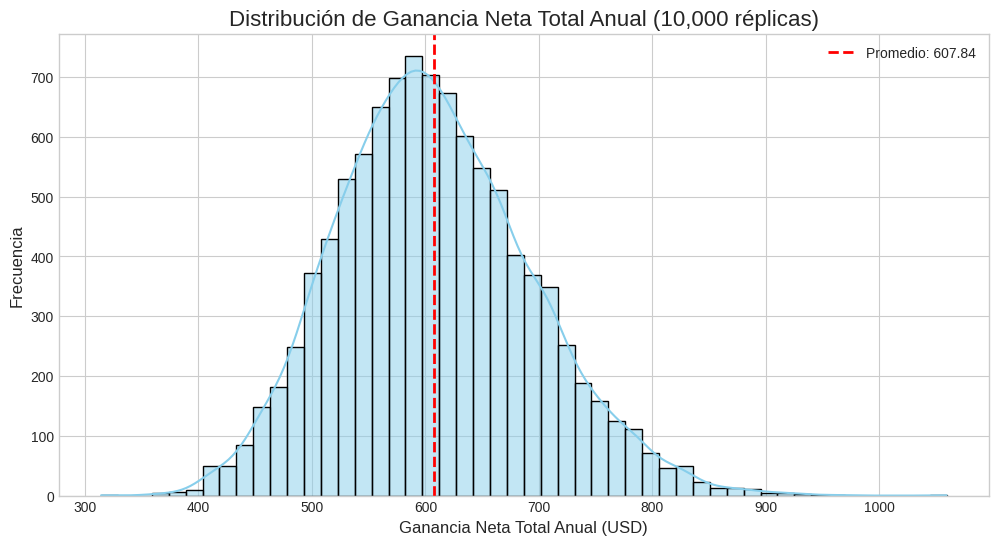

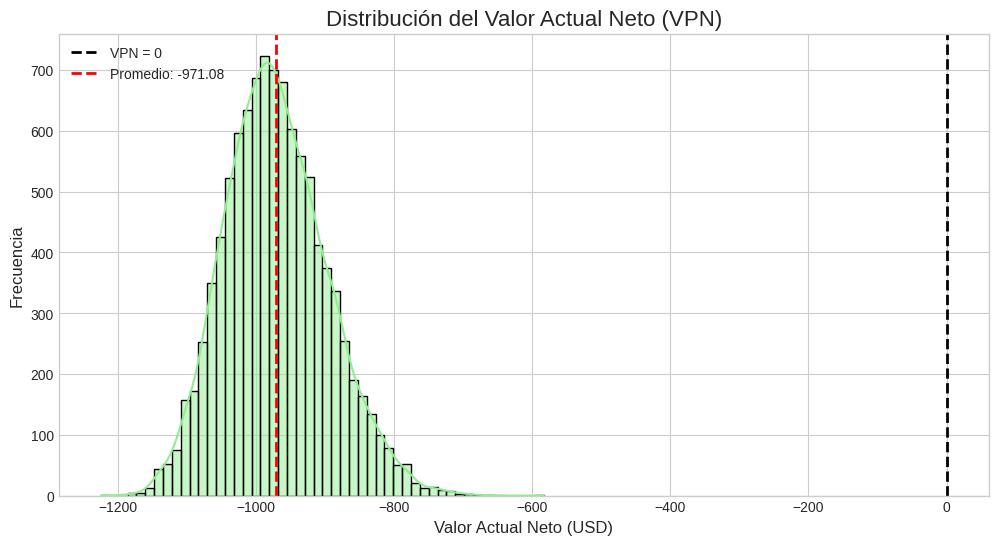

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parámetros de la Simulación ---
num_replicas = 10000
num_meses = 12

# --- Parámetros del Acuerdo ---
inversion_inicial = 1500.0
capital_activo_porcentaje = 0.30
rentabilidad_anual_media = 0.86
desviacion_rentabilidad = 0.35  # 35% de incertidumbre
costo_tributario_porcentaje = 0.21
reinversion_porcentaje = 0.40
costo_operativo_porcentaje = 0.45
tope_costo_operativo_mensual = 300.0
tasa_descuento_anual = 0.25  # Tasa de descuento para el VPN

# --- Almacenar resultados de cada réplica ---
resultados = []

for _ in range(num_replicas):
    capital_base = inversion_inicial
    ganancia_neta_total_replica = 0.0
    flujos_caja_mensuales = []

    for mes in range(num_meses):
        capital_base_inicio_mes = capital_base

        # 1. Determinar el número de operaciones de forma aleatoria (entre 3 y 6)
        num_operaciones = np.random.randint(3, 7)

        for _ in range(num_operaciones):
            # Recalcular el capital activo antes de cada operación
            capital_activo = capital_base * capital_activo_porcentaje

            # Simular la rentabilidad de una única operación
            rentabilidad_mensual_base = (1 + rentabilidad_anual_media)**(1/12) - 1
            rentabilidad_desviacion_mensual = rentabilidad_mensual_base * desviacion_rentabilidad
            rentabilidad_operacion = np.random.normal(rentabilidad_mensual_base, rentabilidad_desviacion_mensual)

            # Calcular la ganancia o pérdida bruta de la operación
            ganancia_bruta_operacion = capital_activo * rentabilidad_operacion

            # Actualizar el capital base inmediatamente después de cada operación
            capital_base += ganancia_bruta_operacion

        # 2. Calcular el margen total del mes y aplicar deducibles y reinversión
        margen_total_mensual = capital_base - capital_base_inicio_mes
        ganancia_neta_mes = 0

        if margen_total_mensual > 0:
            # Aplicar deducciones solo si el margen es positivo
            costo_tributario = margen_total_mensual * costo_tributario_porcentaje
            remanente1 = margen_total_mensual - costo_tributario

            reinversion = remanente1 * reinversion_porcentaje
            remanente2 = remanente1 - reinversion

            costo_operativo = min(remanente2 * costo_operativo_porcentaje, tope_costo_operativo_mensual)

            ganancia_neta_mes = remanente2 - costo_operativo

            # La reinversión ya está incluida en el capital base, pero debe ser sumada al final del mes
            # Se ajusta la lógica para que el capital base del próximo mes sea el actual + la reinversión
            capital_base += reinversion

        # Acumular ganancia neta total del año y flujos de caja
        ganancia_neta_total_replica += ganancia_neta_mes
        flujos_caja_mensuales.append(ganancia_neta_mes)

    # 3. Calcular el Valor Actual Neto (VPN) al final de la réplica
    tasa_descuento_mensual = (1 + tasa_descuento_anual)**(1/12) - 1

    vpn = -inversion_inicial
    for i, flujo in enumerate(flujos_caja_mensuales):
        vpn += flujo / (1 + tasa_descuento_mensual)**(i + 1)

    resultados.append({
        'ganancia_neta_total': ganancia_neta_total_replica,
        'capital_base_final': capital_base,
        'vpn': vpn
    })

# Convertir resultados a DataFrame para un mejor análisis
df_resultados = pd.DataFrame(resultados)

# --- Impresión de Resultados ---
print(f"Número de réplicas: {num_replicas}\n")
print("--- ANÁLISIS DE RESULTADOS DE LA SIMULACIÓN DE MONTECARLO ---")
print("----------------------------------------------------------\n")

print("--- Análisis de Ganancia Neta Total Anual ---")
print(f"Promedio: USD {df_resultados['ganancia_neta_total'].mean():.2f}")
print(f"Mediana: USD {df_resultados['ganancia_neta_total'].median():.2f}")
print(f"Percentil 10 (Escenario Pesimista): USD {df_resultados['ganancia_neta_total'].quantile(0.10):.2f}")
print(f"Percentil 90 (Escenario Optimista): USD {df_resultados['ganancia_neta_total'].quantile(0.90):.2f}\n")

print("--- Análisis de Capital Base Total Final ---")
print(f"Promedio: USD {df_resultados['capital_base_final'].mean():.2f}")
print(f"Mediana: USD {df_resultados['capital_base_final'].median():.2f}\n")

print("--- Análisis de Valor Actual Neto (VPN) ---")
print(f"Promedio: USD {df_resultados['vpn'].mean():.2f}")
print(f"Mediana: USD {df_resultados['vpn'].median():.2f}")
print(f"Probabilidad de VPN positivo: {(df_resultados['vpn'] > 0).mean() * 100:.2f}%\n")

print("--- Distribución de Ganancias Atribuibles (Promedio Anual) ---")
ganancia_promedio_neta = df_resultados['ganancia_neta_total'].mean()
ganancia_atribuible_socio_pm = ganancia_promedio_neta * 0.6667
ganancia_atribuible_socio_operativo = ganancia_promedio_neta * 0.3333

print(f"Socio PM: USD {ganancia_atribuible_socio_pm:.2f}")
print(f"Socio Operativo: USD {ganancia_atribuible_socio_operativo:.2f}\n")

# --- Visualización de los resultados ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
sns.histplot(df_resultados['ganancia_neta_total'], kde=True, bins=50, color='skyblue')
plt.title('Distribución de Ganancia Neta Total Anual (10,000 réplicas)', fontsize=16)
plt.xlabel('Ganancia Neta Total Anual (USD)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(df_resultados['ganancia_neta_total'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Promedio: {df_resultados['ganancia_neta_total'].mean():.2f}")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_resultados['vpn'], kde=True, bins=50, color='lightgreen')
plt.title('Distribución del Valor Actual Neto (VPN)', fontsize=16)
plt.xlabel('Valor Actual Neto (USD)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=2, label='VPN = 0')
plt.axvline(df_resultados['vpn'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Promedio: {df_resultados['vpn'].mean():.2f}")
plt.legend()
plt.show()


Número de réplicas: 10000

--- ANÁLISIS DE RESULTADOS DE LA SIMULACIÓN DE MONTECARLO ---
----------------------------------------------------------

--- Análisis de Ganancia Neta Total Anual ---
Promedio: USD 755.73
Mediana: USD 750.50
Percentil 10 (Escenario Pesimista): USD 628.12
Percentil 90 (Escenario Optimista): USD 889.36

--- Análisis de Capital Base Total Final ---
Promedio: USD 4017.64
Mediana: USD 4000.24

--- Análisis de Valor Actual Neto (VPN) ---
Promedio: USD -840.88
Mediana: USD -845.33
Probabilidad de VPN positivo: 0.00%

--- Distribución de Ganancias Atribuibles (Promedio Anual) ---
Socio PM: USD 503.84
Socio Operativo: USD 251.88



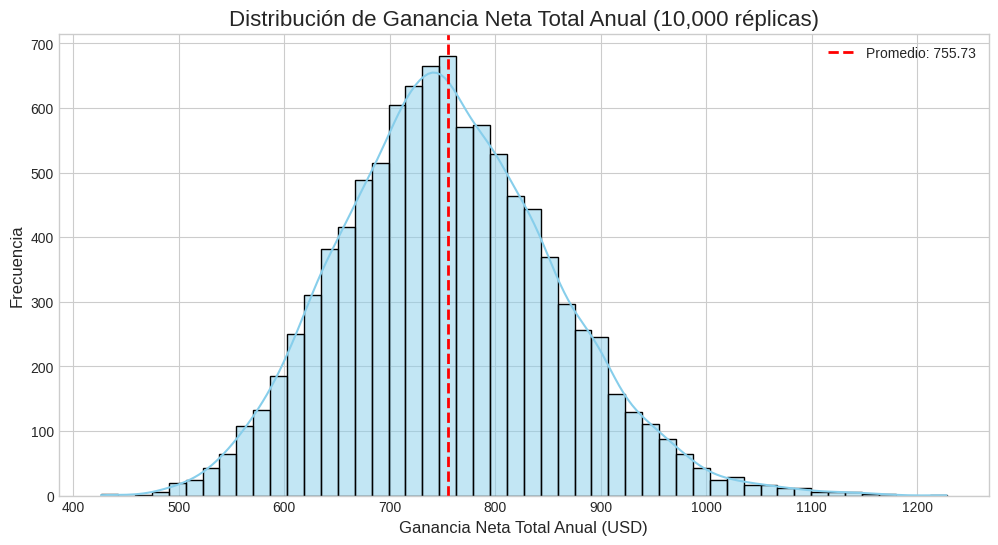

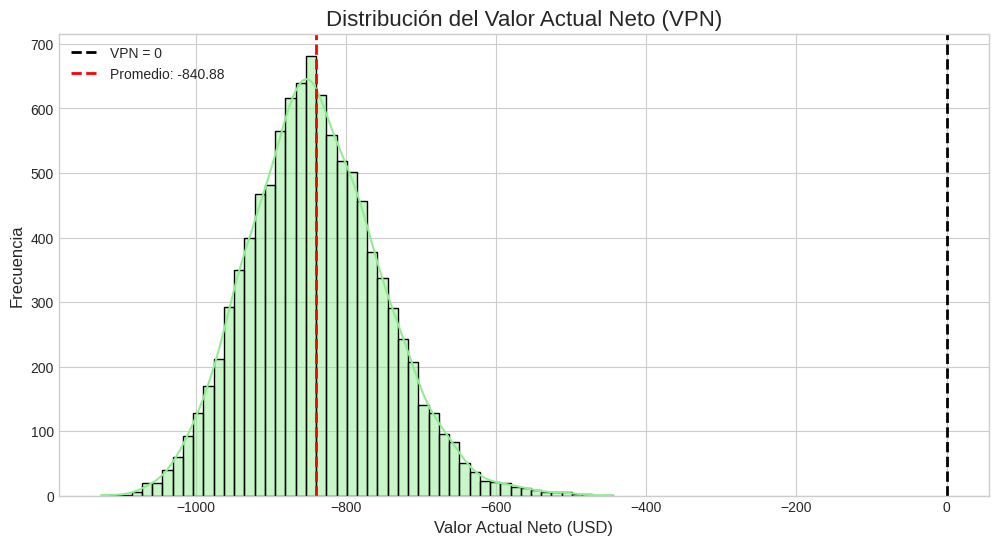

In [ ]:
8import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parámetros de la Simulación ---
num_replicas = 10000
num_meses = 12

# --- Parámetros del Acuerdo ---
inversion_inicial = 1500.0
capital_activo_porcentaje = 0.30
rentabilidad_anual_media = 0.86
desviacion_rentabilidad = 0.35 # 35% de incertidumbre
costo_tributario_porcentaje = 0.21
reinversion_porcentaje = 0.20  # AJUSTE: Reinversión de capital del 20%
tope_costo_operativo_mensual = 300.0
tasa_descuento_anual = 0.25 # Tasa de descuento para el VPN
tope_costo_operativo_anual = tope_costo_operativo_mensual * num_meses # Tope anual

# --- Almacenar resultados de cada réplica ---
resultados = []

for _ in range(num_replicas):
    capital_base = inversion_inicial
    ganancia_neta_total_replica = 0.0
    costos_operativos_acumulados = 0.0
    flujos_caja_mensuales = []

    for mes in range(num_meses):
        capital_base_inicio_mes = capital_base

        # 1. Determinar el número de operaciones de forma aleatoria (entre 3 y 6)
        num_operaciones = np.random.randint(3, 7)

        for _ in range(num_operaciones):
            capital_activo = capital_base * capital_activo_porcentaje
            rentabilidad_mensual_base = (1 + rentabilidad_anual_media)**(1/12) - 1
            rentabilidad_desviacion_mensual = rentabilidad_mensual_base * desviacion_rentabilidad
            rentabilidad_operacion = np.random.normal(rentabilidad_mensual_base, rentabilidad_desviacion_mensual)

            ganancia_bruta_operacion = capital_activo * rentabilidad_operacion
            capital_base += ganancia_bruta_operacion

        # 2. Calcular el margen total del mes y aplicar deducibles
        margen_total_mensual = capital_base - capital_base_inicio_mes
        ganancia_neta_mes = 0

        if margen_total_mensual > 0:
            costo_tributario = margen_total_mensual * costo_tributario_porcentaje
            remanente1 = margen_total_mensual - costo_tributario

            reinversion = remanente1 * reinversion_porcentaje
            remanente2 = remanente1 - reinversion

            costo_operativo = min(remanente2 * costo_operativo_porcentaje, tope_costo_operativo_mensual)

            ganancia_neta_mes = remanente2 - costo_operativo

            capital_base += reinversion
            costos_operativos_acumulados += costo_operativo

        ganancia_neta_total_replica += ganancia_neta_mes
        flujos_caja_mensuales.append(ganancia_neta_mes)

    # 3. Aplicar ajuste de costo operativo anual al final del año
    exceso_costo = 0
    if costos_operativos_acumulados > tope_costo_operativo_anual:
        exceso_costo = costos_operativos_acumulados - tope_costo_operativo_anual
        ganancia_neta_total_replica += exceso_costo
        flujos_caja_mensuales[-1] += exceso_costo # Se suma al último flujo de caja

    # 4. Calcular el Valor Actual Neto (VPN)
    tasa_descuento_mensual = (1 + tasa_descuento_anual)**(1/12) - 1

    vpn = -inversion_inicial
    for i, flujo in enumerate(flujos_caja_mensuales):
        vpn += flujo / (1 + tasa_descuento_mensual)**(i + 1)

    resultados.append({
        'ganancia_neta_total': ganancia_neta_total_replica,
        'capital_base_final': capital_base,
        'vpn': vpn
    })

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)

# --- Impresión de Resultados ---
print(f"Número de réplicas: {num_replicas}\n")
print("--- ANÁLISIS DE RESULTADOS DE LA SIMULACIÓN DE MONTECARLO ---")
print("----------------------------------------------------------\n")

print("--- Análisis de Ganancia Neta Total Anual ---")
print(f"Promedio: USD {df_resultados['ganancia_neta_total'].mean():.2f}")
print(f"Mediana: USD {df_resultados['ganancia_neta_total'].median():.2f}")
print(f"Percentil 10 (Escenario Pesimista): USD {df_resultados['ganancia_neta_total'].quantile(0.10):.2f}")
print(f"Percentil 90 (Escenario Optimista): USD {df_resultados['ganancia_neta_total'].quantile(0.90):.2f}\n")

print("--- Análisis de Capital Base Total Final ---")
print(f"Promedio: USD {df_resultados['capital_base_final'].mean():.2f}")
print(f"Mediana: USD {df_resultados['capital_base_final'].median():.2f}\n")

print("--- Análisis de Valor Actual Neto (VPN) ---")
print(f"Promedio: USD {df_resultados['vpn'].mean():.2f}")
print(f"Mediana: USD {df_resultados['vpn'].median():.2f}")
print(f"Probabilidad de VPN positivo: {(df_resultados['vpn'] > 0).mean() * 100:.2f}%\n")

print("--- Distribución de Ganancias Atribuibles (Promedio Anual) ---")
ganancia_promedio_neta = df_resultados['ganancia_neta_total'].mean()
ganancia_atribuible_socio_pm = ganancia_promedio_neta * 0.6667
ganancia_atribuible_socio_operativo = ganancia_promedio_neta * 0.3333

print(f"Socio PM: USD {ganancia_atribuible_socio_pm:.2f}")
print(f"Socio Operativo: USD {ganancia_atribuible_socio_operativo:.2f}\n")

# --- Visualización de los resultados ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
sns.histplot(df_resultados['ganancia_neta_total'], kde=True, bins=50, color='skyblue')
plt.title('Distribución de Ganancia Neta Total Anual (10,000 réplicas)', fontsize=16)
plt.xlabel('Ganancia Neta Total Anual (USD)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(df_resultados['ganancia_neta_total'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Promedio: {df_resultados['ganancia_neta_total'].mean():.2f}")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_resultados['vpn'], kde=True, bins=50, color='lightgreen')
plt.title('Distribución del Valor Actual Neto (VPN)', fontsize=16)
plt.xlabel('Valor Actual Neto (USD)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=2, label='VPN = 0')
plt.axvline(df_resultados['vpn'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Promedio: {df_resultados['vpn'].mean():.2f}")
plt.legend()
plt.show()

Simulacion con alta incertumbre pero aplicando estrategia de " Salva vida" atribuible al VPN

Número de réplicas: 10000

--- ANÁLISIS DE RESULTADOS DE LA SIMULACIÓN DE MONTECARLO CON ESTRATEGIA ---
----------------------------------------------------------

--- Análisis de Ganancia Neta Total Anual ---
Promedio: USD 608.25
Mediana: USD 603.80
Percentil 10 (Escenario Pesimista): USD 500.11
Percentil 90 (Escenario Optimista): USD 722.56

--- Análisis de Ajuste en Capital Base para lograr VPN = 0 ---
Promedio de ajuste: USD 970.71
Mediana de ajuste: USD 974.42

--- Análisis de Capital Base Total Final (Ajustado) ---
Promedio: USD 3599.72
Mediana: USD 3573.51

--- Análisis de Valor Actual Neto (VPN) ---
Promedio: USD 0.00
Mediana: USD 0.00
Probabilidad de VPN positivo: 0.00%

--- Distribución de Ganancias Atribuibles (Promedio Anual) ---
Socio PM: USD 405.52
Socio Operativo: USD 202.73



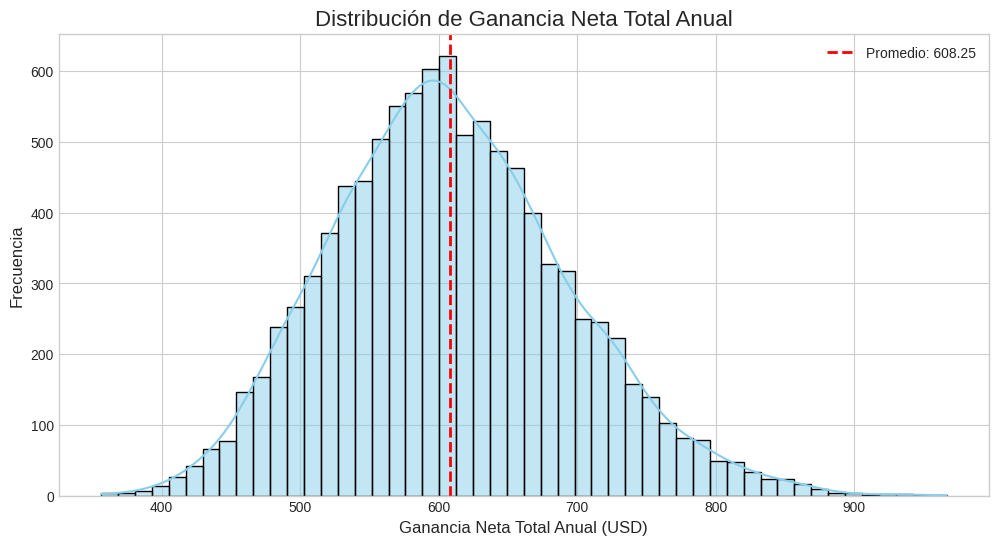

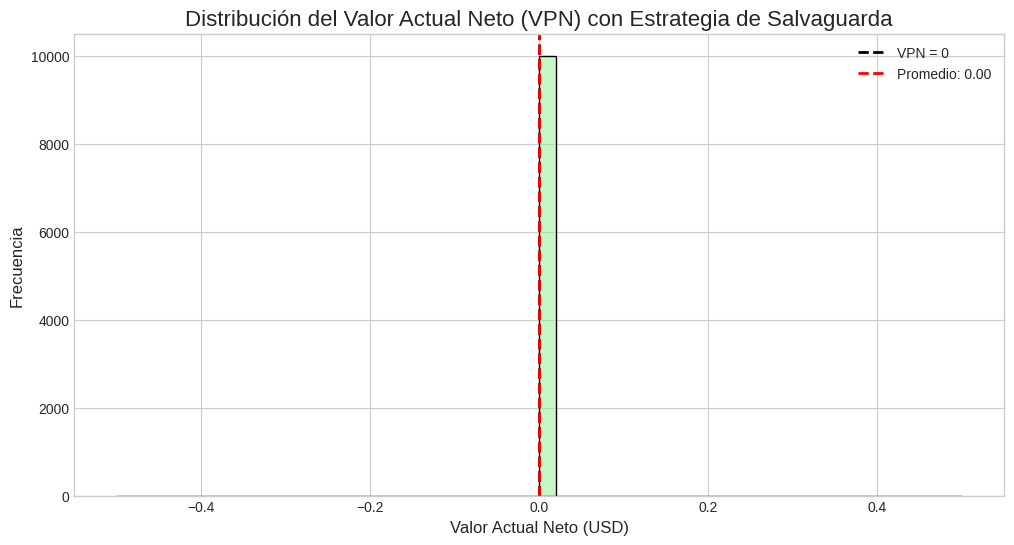

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parámetros de la Simulación ---
num_replicas = 10000
num_meses = 12

# --- Parámetros del Acuerdo ---
inversion_inicial = 1500.0
capital_activo_porcentaje = 0.30
rentabilidad_anual_media = 0.86
desviacion_rentabilidad = 0.35  # 35% de incertidumbre
costo_tributario_porcentaje = 0.21
reinversion_porcentaje = 0.40
costo_operativo_porcentaje = 0.45
tope_costo_operativo_mensual = 300.0
tasa_descuento_anual = 0.25  # Tasa de descuento para el VPN

# --- Almacenar resultados de cada réplica ---
resultados = []
ajustes_capital_base = [] # Lista para almacenar los ajustes

for _ in range(num_replicas):
    capital_base = inversion_inicial
    ganancia_neta_total_replica = 0.0
    flujos_caja_mensuales = []

    for mes in range(num_meses):
        capital_base_inicio_mes = capital_base

        # 1. Determinar el número de operaciones de forma aleatoria (entre 3 y 6)
        num_operaciones = np.random.randint(3, 7)

        for _ in range(num_operaciones):
            # Recalcular el capital activo antes de cada operación
            capital_activo = capital_base * capital_activo_porcentaje

            # Simular la rentabilidad de una única operación
            rentabilidad_mensual_base = (1 + rentabilidad_anual_media)**(1/12) - 1
            rentabilidad_desviacion_mensual = rentabilidad_mensual_base * desviacion_rentabilidad
            rentabilidad_operacion = np.random.normal(rentabilidad_mensual_base, rentabilidad_desviacion_mensual)

            # Calcular la ganancia o pérdida bruta de la operación
            ganancia_bruta_operacion = capital_activo * rentabilidad_operacion

            # Actualizar el capital base inmediatamente después de cada operación
            capital_base += ganancia_bruta_operacion

        # 2. Calcular el margen total del mes y aplicar deducibles y reinversión
        margen_total_mensual = capital_base - capital_base_inicio_mes
        ganancia_neta_mes = 0

        if margen_total_mensual > 0:
            # Aplicar deducciones solo si el margen es positivo
            costo_tributario = margen_total_mensual * costo_tributario_porcentaje
            remanente1 = margen_total_mensual - costo_tributario

            reinversion = remanente1 * reinversion_porcentaje
            remanente2 = remanente1 - reinversion

            costo_operativo = min(remanente2 * costo_operativo_porcentaje, tope_costo_operativo_mensual)

            ganancia_neta_mes = remanente2 - costo_operativo

            # La reinversión ya está incluida en el capital base, pero debe ser sumada al final del mes
            # Se ajusta la lógica para que el capital base del próximo mes sea el actual + la reinversión
            capital_base += reinversion

        # Acumular ganancia neta total del año y flujos de caja
        ganancia_neta_total_replica += ganancia_neta_mes
        flujos_caja_mensuales.append(ganancia_neta_mes)

    # 3. Calcular el Valor Actual Neto (VPN) al final de la réplica
    tasa_descuento_mensual = (1 + tasa_descuento_anual)**(1/12) - 1

    vpn = -inversion_inicial
    for i, flujo in enumerate(flujos_caja_mensuales):
        vpn += flujo / (1 + tasa_descuento_mensual)**(i + 1)

    # 4. Aplicación de la Estrategia de Acción Condicional
    ajuste_necesario = 0
    if vpn < 0:
        ajuste_necesario = abs(vpn)

        # El ajuste se deduce del capital base al final de la réplica
        capital_base -= ajuste_necesario
        vpn = 0 # El VPN ajustado es 0

    ajustes_capital_base.append(ajuste_necesario)

    resultados.append({
        'ganancia_neta_total': ganancia_neta_total_replica,
        'capital_base_final': capital_base,
        'vpn': vpn
    })

# Convertir resultados a DataFrame para un mejor análisis
df_resultados = pd.DataFrame(resultados)
df_ajustes = pd.DataFrame(ajustes_capital_base, columns=['ajuste_vpn_a_cero'])

# --- Impresión de Resultados ---
print(f"Número de réplicas: {num_replicas}\n")
print("--- ANÁLISIS DE RESULTADOS DE LA SIMULACIÓN DE MONTECARLO CON ESTRATEGIA ---")
print("----------------------------------------------------------\n")

print("--- Análisis de Ganancia Neta Total Anual ---")
print(f"Promedio: USD {df_resultados['ganancia_neta_total'].mean():.2f}")
print(f"Mediana: USD {df_resultados['ganancia_neta_total'].median():.2f}")
print(f"Percentil 10 (Escenario Pesimista): USD {df_resultados['ganancia_neta_total'].quantile(0.10):.2f}")
print(f"Percentil 90 (Escenario Optimista): USD {df_resultados['ganancia_neta_total'].quantile(0.90):.2f}\n")

print("--- Análisis de Ajuste en Capital Base para lograr VPN = 0 ---")
print(f"Promedio de ajuste: USD {df_ajustes['ajuste_vpn_a_cero'].mean():.2f}")
print(f"Mediana de ajuste: USD {df_ajustes['ajuste_vpn_a_cero'].median():.2f}\n")

print("--- Análisis de Capital Base Total Final (Ajustado) ---")
print(f"Promedio: USD {df_resultados['capital_base_final'].mean():.2f}")
print(f"Mediana: USD {df_resultados['capital_base_final'].median():.2f}\n")

print("--- Análisis de Valor Actual Neto (VPN) ---")
print(f"Promedio: USD {df_resultados['vpn'].mean():.2f}")
print(f"Mediana: USD {df_resultados['vpn'].median():.2f}")
print(f"Probabilidad de VPN positivo: {(df_resultados['vpn'] > 0).mean() * 100:.2f}%\n")

print("--- Distribución de Ganancias Atribuibles (Promedio Anual) ---")
ganancia_promedio_neta = df_resultados['ganancia_neta_total'].mean()
ganancia_atribuible_socio_pm = ganancia_promedio_neta * 0.6667
ganancia_atribuible_socio_operativo = ganancia_promedio_neta * 0.3333

print(f"Socio PM: USD {ganancia_atribuible_socio_pm:.2f}")
print(f"Socio Operativo: USD {ganancia_atribuible_socio_operativo:.2f}\n")

# --- Visualización de los resultados ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
sns.histplot(df_resultados['ganancia_neta_total'], kde=True, bins=50, color='skyblue')
plt.title('Distribución de Ganancia Neta Total Anual', fontsize=16)
plt.xlabel('Ganancia Neta Total Anual (USD)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(df_resultados['ganancia_neta_total'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Promedio: {df_resultados['ganancia_neta_total'].mean():.2f}")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_resultados['vpn'], kde=True, bins=50, color='lightgreen')
plt.title('Distribución del Valor Actual Neto (VPN) con Estrategia de Salvaguarda', fontsize=16)
plt.xlabel('Valor Actual Neto (USD)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=2, label='VPN = 0')
plt.axvline(df_resultados['vpn'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Promedio: {df_resultados['vpn'].mean():.2f}")
plt.legend()
plt.show()
